In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
import os
import tensorflow
import albumentations
import cv2
import time
import torch
import scipy
import segmentation_models_pytorch  as smp
import torch.nn.functional          as F
import torch.nn                     as nn
import numpy                        as np # linear algebra
import pandas                       as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot            as plt
from PIL                import Image
from tqdm.notebook      import tqdm
from torchvision        import transforms as T
from torch.utils.data   import Dataset, DataLoader

kagglehub.login()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

covid_segmentation_path = kagglehub.competition_download('covid-segmentation')

print('Data source import complete.')


In [ ]:
pip install segmentation-models-pytorch

^C


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-segmentation/masks_medseg.npy
/kaggle/input/covid-segmentation/images_medseg.npy
/kaggle/input/covid-segmentation/test_images_medseg.npy
/kaggle/input/covid-segmentation/masks_radiopedia.npy
/kaggle/input/covid-segmentation/images_radiopedia.npy


In [ ]:
prefix = '/kaggle/input/covid-segmentation/'

images_radiopedia  = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia   = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
images_medseg      = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg       = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)
test_images_medseg = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)

In [ ]:
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8, hot_encode=True):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    _, ax       = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        if hot_encode:
            ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        else:
            ax_image.imshow(image_batch[i,:,:])
        ax_image.set_xticks([])
        ax_image.set_yticks([])

        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3))
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([])
                ax[j + 1, i].set_yticks([])

    plt.tight_layout()
    plt.show()

In [ ]:
def onehot_to_mask(mask, palette):
    """
    Converts a mask (H, W, K) to (H, W, C)
    """
    x = np.argmax(mask, axis=-1)
    colour_codes = np.array(palette)
    x = np.uint8(colour_codes[x.astype(np.uint8)])
    return x

In [ ]:
def preprocess_images(images_arr, mean_std=None):
    images_arr[images_arr > 500]    = 500
    images_arr[images_arr < -1500]  = -1500
    min_perc, max_perc  = np.percentile(images_arr, 5), np.percentile(images_arr, 95)
    images_arr_valid    = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]
    mean, std           = (images_arr_valid.mean(), images_arr_valid.std()) if mean_std is None else mean_std
    images_arr          = (images_arr - mean) / std
    print(f'mean {mean}, std {std}')
    return images_arr, (mean, std)

In [ ]:
def plot_hists(images1, images2=None):
    plt.hist(images1.ravel(), bins=100, density=True, color='b', alpha=1 if images2 is None else 0.5)
    if images2 is not None:
        plt.hist(images2.ravel(), bins=100, density=True, alpha=0.5, color='orange')
    plt.show()

In [ ]:
def mask_to_onehot(mask, palette):
    """
    Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one
    hot encoding vector, C is usually 1 or 3, and K is the number of class.
    """
    semantic_map = []
    for colour in palette:
        #print('colour',colour)
        equality = np.equal(mask, colour)
        #print('equality',equality)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return torch.from_numpy(semantic_map)

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    #torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data

            image = image_tiles.to(device); mask =mask_tiles.to(device);
            #forward
            output = model(image)

            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()


        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data

                    image = image_tiles.to(device); mask =mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet_efficientnet_b2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485], std=[0.229]):
    model.eval()
    #t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    #image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)


    with torch.no_grad():

        #image = image.unsqueeze(0)
        #mask = mask.unsqueeze(0)

        output = model(image)
        a,b,c,d = output.shape
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score, output.permute(0, 2, 3,1)

In [ ]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

### Images from radiopedia are full CT volumes:
Class 0 is "ground glass"<br>
Class 1 is "consolidations"<br>
Class 2 is "lungs other" – it doesn't mean that it is healthy lungs (you don't need to predict this class)<br>
Class 3 is "background" – not lungs (you don't need to predict this class)<br>

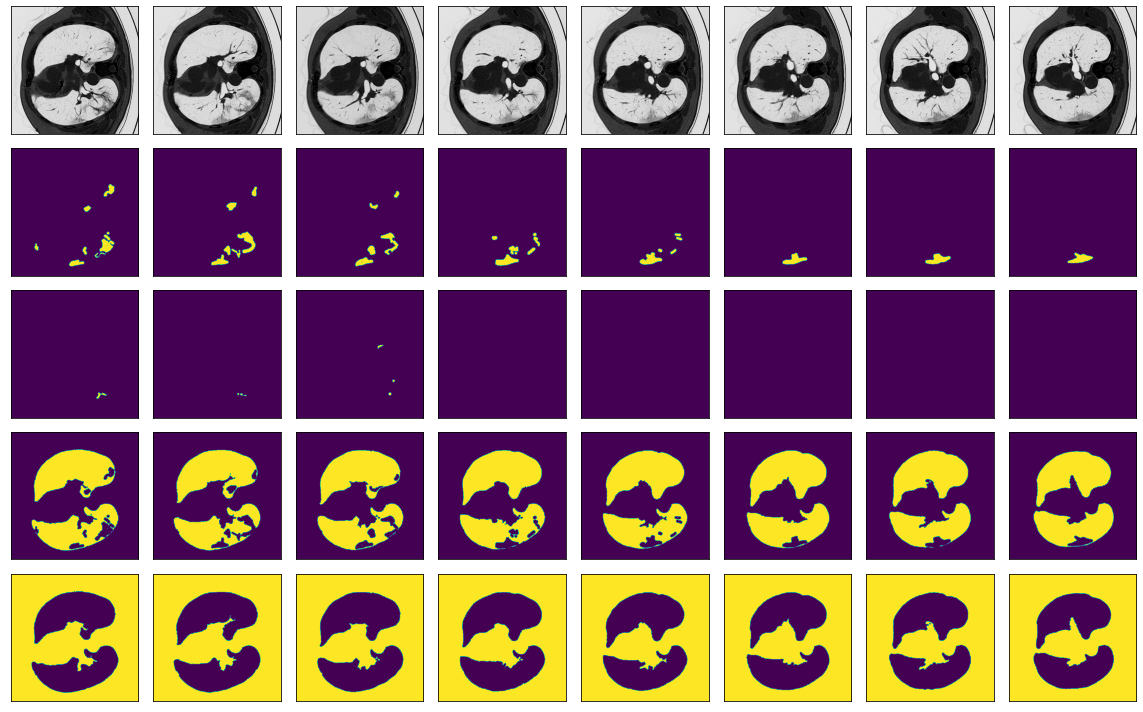

In [ ]:
visualize(images_radiopedia[30:], masks_radiopedia[30:])

Hot encoded mask size:  (829, 512, 512, 4)
Paletted mask size: (100, 512, 512)


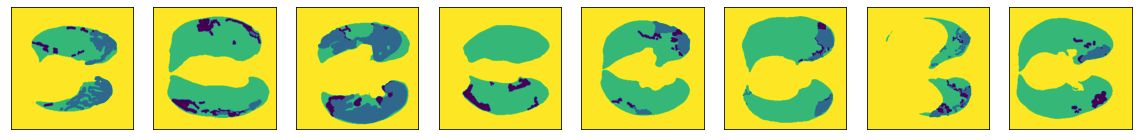

In [ ]:
palette = [[0], [1], [2],[3]]
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)

masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)

print('Hot encoded mask size: ',masks_radiopedia.shape)
print('Paletted mask size:',masks_medseg_recover.shape)

visualize(masks_medseg_recover[30:],hot_encode=False)

### Preprocess images:

In [ ]:
images_radiopedia, mean_std = preprocess_images(images_radiopedia)
images_medseg, _            = preprocess_images(images_medseg, mean_std)
test_images_medseg, _       = preprocess_images(test_images_medseg, mean_std)

mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281


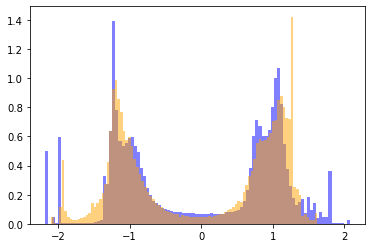

In [ ]:
plot_hists(test_images_medseg, images_radiopedia)

## Split train / val:

In [ ]:
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)
masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)


val_indexes, train_indexes = list(range(24)), list(range(24, 100))

train_images = np.concatenate((images_medseg[train_indexes], images_radiopedia))
train_masks = np.concatenate((masks_medseg_recover[train_indexes], masks_radiopedia_recover))
val_images = images_medseg[val_indexes]
val_masks = masks_medseg_recover[val_indexes]

batch_size = len(val_masks)

del masks_medseg_recover
del masks_radiopedia_recover
del images_radiopedia
del masks_radiopedia
del images_medseg
del masks_medseg

## Data generator and augmentations:

In [ ]:
SOURCE_SIZE = 512
TARGET_SIZE = 256


train_augs = albumentations.Compose([
    albumentations.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_REPLICATE),
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE),
                                   TARGET_SIZE,
                                   TARGET_SIZE,
                                   interpolation=cv2.INTER_NEAREST),
    albumentations.HorizontalFlip(p=0.5),

])

val_augs = albumentations.Compose([
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
])

In [ ]:
class Dataset:
    def __init__(
            self,
            images,
            masks,
            augmentations=None
    ):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
        self.mean = [0.485]
        self.std = [0.229]

    def __getitem__(self, i):
        image = self.images[i]
        mask = self.masks[i]


        if self.augmentations is not None:
            sample = self.augmentations(image=image, mask=mask)

            image, mask = Image.fromarray(np.squeeze(sample['image'], axis=2)), sample['mask']

        if self.augmentations is None:
            image = Image.fromarray(image)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        image = t(image)
        mask = torch.from_numpy(mask).long()

        return image, mask

    def __len__(self):
        return len(self.images)

    def tiles(self, image, mask):

        img_patches = image.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches


train_dataset = Dataset(train_images, train_masks, train_augs)
val_dataset = Dataset(val_images, val_masks, val_augs)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

ModuleNotFoundError: No module named 'segmentation_models_pytorch'

In [ ]:
i,train_data = next(enumerate(train_dataloader))

mask_hot_encoded = mask_to_onehot(torch.unsqueeze(train_data[1],-1).numpy(),palette)
#visualize(torch.unsqueeze(torch.squeeze(train_data[0],1),-1),mask_hot_encoded)
visualize(train_data[0].permute(0, 2, 3,1),mask_hot_encoded)


In [ ]:
model = smp.Unet('efficientnet-b2',in_channels=1, encoder_weights='imagenet',classes=4, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
#decoder_attention_type ='scse'

In [ ]:
max_lr = 1e-3
epoch = 10
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_dataloader))

history = fit(epoch, model, train_dataloader, val_dataloader, criterion, optimizer, sched)

In [ ]:
torch.save(model, 'Unet-efficientnet.pt')

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# Evaluation
## Result

In [ ]:
image, mask = next(iter(val_dataloader))
pred_mask, score,output = predict_image_mask_miou(model, image, mask)
semantic_map = mask_to_onehot(torch.unsqueeze(mask,-1).numpy(),palette)

In [ ]:
visualize(image, semantic_map, pred_batch=output)

# yellow is TP, red is FP, green is FN

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i, data in enumerate(tqdm(test_set)):
        img, mask = data
        pred_mask, score,output = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = miou_score(model, val_dataloader)
mob_miou

In [ ]:
del train_images
del train_masks

## Test preds:

In [ ]:
image_batch = np.stack([val_augs(image=img)['image'] for img in test_images_medseg], axis=0)
print(torch.from_numpy(image_batch).shape)
print(image_batch[i].shape)
#output = test_predict(model, torch.from_numpy(image_batch).permute(0, 3, 1,2))
output = np.zeros((10,256,256,4))
for i in range(10):
    output[i] = test_predict(model, image_batch[i])
print(output.shape)
test_masks_prediction = output > 0.5
visualize(image_batch, test_masks_prediction, num_samples=len(test_images_medseg))

## Resize prediction to original size:

In [ ]:
test_masks_prediction_original_size = scipy.ndimage.zoom(test_masks_prediction[..., :-2], (1, 2, 2, 1), order=0)
test_masks_prediction_original_size.shape

In [ ]:
pd.DataFrame(
             data=np.stack((np.arange(len(test_masks_prediction_original_size.ravel())),
                            test_masks_prediction_original_size.ravel().astype(int)),
                            axis=-1),
             columns=['Id', 'Predicted'])\
.set_index('Id').to_csv('sub.csv')